# Prueba Claro
## Frank Montenegro - frandak2@gmail.com

### importamos las librerias que vamos a usar

In [19]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

### redireccionamos la ruta del notebook

In [20]:
import os
g = os.getcwd()
g
path = 'D:\\repos\\GEO_claro'
os.chdir(path)

## Procedemos a leer los archivos CSV
### De antemano sabemos que es informacion de todo el pais en temas de internet

In [21]:
latencia = pd.read_csv('data\Prueba_geo.csv', delimiter = ";")#leemos el csv
print(latencia.shape)
latencia.head(5)


(11703072, 8)


,FECHA,TEST_ID,DOWNLOAD_KBPS,UPLOAD_KBPS,LATENCY,LATITUD,LONGITUD,N_OPERADOR
0,2021-01-16,4369477252,82953,7702,12,4.649,-74.061,4
1,2021-01-16,6936985161,54079,7593,12,4.649,-74.061,4
2,2021-01-16,6936673152,20890,3382,12,4.649,-74.061,4
3,2021-01-16,4368755858,35068,8498,12,4.649,-74.061,4
4,2021-01-16,4369836498,72701,10532,12,4.649,-74.061,4


In [22]:
latencia.info()#observamos que tipo de info tiene el csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703072 entries, 0 to 11703071
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   FECHA          object 
 1   TEST_ID        int64  
 2   DOWNLOAD_KBPS  int64  
 3   UPLOAD_KBPS    int64  
 4   LATENCY        int64  
 5   LATITUD        float64
 6   LONGITUD       float64
 7   N_OPERADOR     int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 714.3+ MB


### tenemos 11'703.072 de registros de latencia, subida y descarga en velocidades de internet, tambien observamos fechas y cordenadas lo que es fundamental para hacer nuestro analisis espacial


In [23]:
lat_copy = latencia.copy() #creamos copia de la bd
lat_copy['DOWNLOAD_MBPS'] = lat_copy.DOWNLOAD_KBPS * 0.0009765625 #transformamos de KB a MB
lat_copy['UPLOAD_MBPS'] = lat_copy.UPLOAD_KBPS * 0.0009765625 #transformamos de KB a MB
lat_copy.info()#observamos que tipo de info tiene

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703072 entries, 0 to 11703071
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   FECHA          object 
 1   TEST_ID        int64  
 2   DOWNLOAD_KBPS  int64  
 3   UPLOAD_KBPS    int64  
 4   LATENCY        int64  
 5   LATITUD        float64
 6   LONGITUD       float64
 7   N_OPERADOR     int64  
 8   DOWNLOAD_MBPS  float64
 9   UPLOAD_MBPS    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 892.9+ MB


In [24]:
lat_copy["CLASS_LATE"] = np.where(lat_copy['LATENCY'] >= 10, 0, 1)
# lat_copy.head(6)
lat_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703072 entries, 0 to 11703071
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   FECHA          object 
 1   TEST_ID        int64  
 2   DOWNLOAD_KBPS  int64  
 3   UPLOAD_KBPS    int64  
 4   LATENCY        int64  
 5   LATITUD        float64
 6   LONGITUD       float64
 7   N_OPERADOR     int64  
 8   DOWNLOAD_MBPS  float64
 9   UPLOAD_MBPS    float64
 10  CLASS_LATE     int32  
dtypes: float64(4), int32(1), int64(5), object(1)
memory usage: 937.5+ MB


In [25]:
lat_copy.drop(columns=['DOWNLOAD_KBPS', 'UPLOAD_KBPS', 'LATENCY'], inplace=True)

In [26]:
gdf = gpd.GeoDataFrame(
    lat_copy, geometry=gpd.points_from_xy(lat_copy.LONGITUD, lat_copy.LATITUD))
gdf = gdf.set_crs(epsg=4326)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
localidades = gpd.read_file('data\localidades\localidades_data.shp') #leemos el shape de localiades enriquecido
localidades.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
localidades = localidades[(localidades.NOMBRE!='CIUDAD BOLIVAR') & (localidades.NOMBRE!='USME')]
localidades.NOMBRE

0         ANTONIO NARIÑO
1         BARRIOS UNIDOS
2                   BOSA
3             CANDELARIA
4              CHAPINERO
6               ENGATIVA
7               FONTIBON
8                KENNEDY
9           LOS MARTIRES
10         PUENTE ARANDA
11    RAFAEL URIBE URIBE
12         SAN CRISTOBAL
13              SANTA FE
14                  SUBA
15           TEUSAQUILLO
16            TUNJUELITO
17               USAQUEN
Name: NOMBRE, dtype: object

In [29]:
def get_pip (points, polygons):

    names_localidades = list(polygons.NOMBRE)
    
    df = pd.DataFrame()#creamos un dataframe vacio
    for name_locali in names_localidades:

        pol = (polygons.loc[polygons.NOMBRE==name_locali]) #seleccionamos la geometria por localidad

        pol.reset_index(drop = True, inplace = True)

        pip_mask = points.within(pol.loc[0, 'geometry']) # seleciona que puntos se cruzan con la localidad

        pip_data = points.loc[pip_mask].copy()# selecionamos solo los puntos que se intersectan

        pip_data['localidad']= name_locali # creamos una nueva columna con el nombre de la localidad

        df = df.append(pip_data) # agregamos los puntos con su localidad a df vacio
        print('voy aqui: ', name_locali)

    return df

bgt_df = get_pip(gdf, localidades)

voy aqui:  ANTONIO NARIÑO
voy aqui:  BARRIOS UNIDOS
voy aqui:  BOSA
voy aqui:  CANDELARIA
voy aqui:  CHAPINERO
voy aqui:  ENGATIVA
voy aqui:  FONTIBON
voy aqui:  KENNEDY
voy aqui:  LOS MARTIRES
voy aqui:  PUENTE ARANDA
voy aqui:  RAFAEL URIBE URIBE
voy aqui:  SAN CRISTOBAL
voy aqui:  SANTA FE
voy aqui:  SUBA
voy aqui:  TEUSAQUILLO
voy aqui:  TUNJUELITO
voy aqui:  USAQUEN


In [30]:
bgt_df = gpd.GeoDataFrame(bgt_df.drop(columns=['LATITUD','LONGITUD']),crs="EPSG:4326")# creamos un geopandas sin las columnas de lat y lon
bgt_df.head(5)


,FECHA,TEST_ID,N_OPERADOR,DOWNLOAD_MBPS,UPLOAD_MBPS,CLASS_LATE,geometry,localidad
29240,2021-01-28,6978771403,4,10.410156,0.640625,0,POINT (-74.09600 4.58700),ANTONIO NARIÑO
29977,2021-01-19,6945885369,4,10.294922,4.988281,0,POINT (-74.12100 4.59200),ANTONIO NARIÑO
30558,2021-01-08,6907797685,4,28.707031,4.711914,0,POINT (-74.10000 4.59000),ANTONIO NARIÑO
31883,2021-01-21,6953823661,4,53.502930,7.201172,0,POINT (-74.09500 4.58500),ANTONIO NARIÑO
32110,2021-01-21,6952553476,4,26.608398,6.316406,0,POINT (-74.12100 4.59300),ANTONIO NARIÑO


In [31]:
bgt_df.to_file('data/points_ok/late_bgt.shp')

C:\Users\FRANKH~1\AppData\Local\Temp/ipykernel_17980/364429791.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bgt_df.to_file('data/points_ok/late_bgt.shp')


La fecha al ser un tipo especial lo cambiaremos manualmente

In [32]:
bgt_df['FECHA'] = pd.to_datetime(bgt_df['FECHA'])
bgt_df['FECHA'] # en formato datetime

29240      2021-01-28
29977      2021-01-19
30558      2021-01-08
31883      2021-01-21
32110      2021-01-21
              ...    
11703067   2021-09-27
11703068   2021-09-26
11703069   2021-09-27
11703070   2021-09-27
11703071   2021-09-27
Name: FECHA, Length: 4747929, dtype: datetime64[ns]

Como sabemos que tenemos un columna N operadores en tipo string la pasamos a tipo categorical.

In [33]:
bgt_df['N_OPERADOR'] = pd.Categorical(bgt_df['N_OPERADOR'], categories=[1,2,3,4],ordered=False)

In [34]:
bgt_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4747929 entries, 29240 to 11703071
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   FECHA          datetime64[ns]
 1   TEST_ID        int64         
 2   N_OPERADOR     category      
 3   DOWNLOAD_MBPS  float64       
 4   UPLOAD_MBPS    float64       
 5   CLASS_LATE     int32         
 6   geometry       geometry      
 7   localidad      object        
dtypes: category(1), datetime64[ns](1), float64(2), geometry(1), int32(1), int64(1), object(1)
memory usage: 276.2+ MB


In [35]:
#sacamos la informacion por mes
bgt_df['MES'] = pd.DatetimeIndex(bgt_df['FECHA']).month_name()
bgt_df['MES'] = pd.Categorical(bgt_df['MES'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September'], ordered=True)
#sacamos la informacion por el nombre del dia
bgt_df['DIA'] = pd.DatetimeIndex(bgt_df['FECHA']).day_name()
bgt_df['DIA'] = pd.Categorical(bgt_df['DIA'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)




### Distribucion de descarga por tipo de forma

<Figure size 1440x720 with 0 Axes>

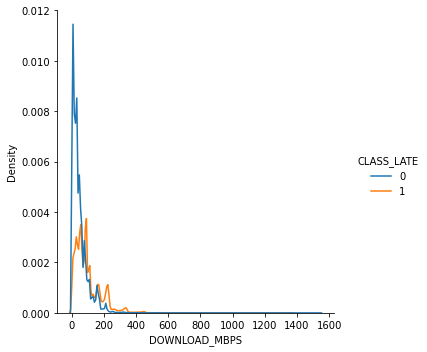

In [36]:
plt.figure(figsize=(20,10))
sns.displot(data=bgt_df, x='DOWNLOAD_MBPS', hue="CLASS_LATE", kind="kde")


<AxesSubplot:xlabel='localidad', ylabel='DOWNLOAD_MBPS'>

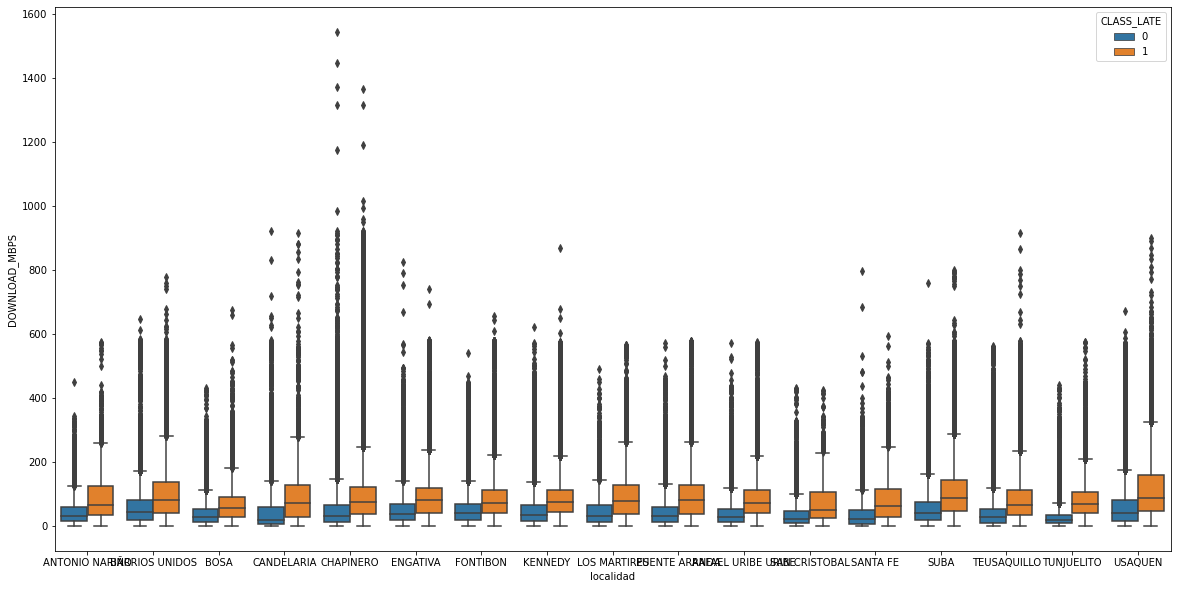

In [37]:
plt.figure(figsize=(20,10))
sns.boxplot(x='localidad', y="DOWNLOAD_MBPS", data=bgt_df, hue='CLASS_LATE')

In [38]:
bgt_df_D = bgt_df[np.abs(bgt_df.DOWNLOAD_MBPS-bgt_df.DOWNLOAD_MBPS.mean())<=(3*bgt_df.DOWNLOAD_MBPS.std())] #Eliminamos los outliers usando la media y la STD


<Figure size 1440x720 with 0 Axes>

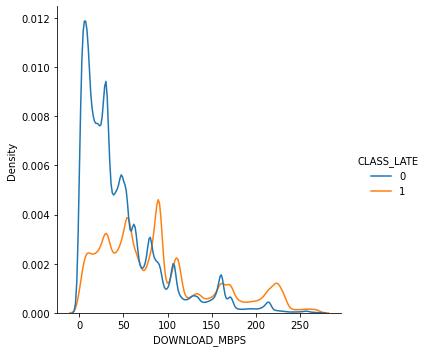

In [39]:
plt.figure(figsize=(20,10))
sns.hisplot(data=bgt_df_D, x='DOWNLOAD_MBPS', hue="CLASS_LATE", kind="kde")

In [40]:
def density(df, col):
    print('visualizamos desidad total')
    plt.figure(figsize=(20,10))
    g = sns.displot(data=df, x=col, hue="CLASS_LATE", kind="kde")
    print(g)
    print('visualizamos desidad por mes')
    plt.figure(figsize=(20,10))
    g = sns.boxplot(x='localidad', y=col, data=df, hue='CLASS_LATE')
    print(g)
    #Eliminamos los outliers usando la media y la STD
    df_clean = df[np.abs(df[col]-df[col].mean())<=(3*df[col].std())] 
    print('visualizamos desidad total limpia')
    plt.figure(figsize=(20,10))
    g = sns.displot(data=df_clean, x=col, hue="CLASS_LATE", kind="kde")
    print(g)
    print('visualizamos desidad por mes limpia')
    plt.figure(figsize=(20,10))
    g = sns.boxplot(x='localidad', y=col, data=df_clean, hue='CLASS_LATE')
    print(g)
    return df_clean

visualizamos desidad total
visualizamos desidad por mes
AxesSubplot(0.125,0.125;0.775x0.755)
visualizamos desidad total limpia
visualizamos desidad por mes limpia
AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 1440x720 with 0 Axes>

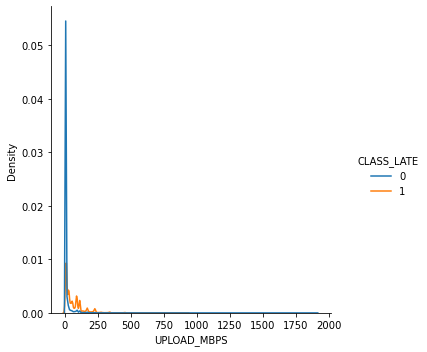

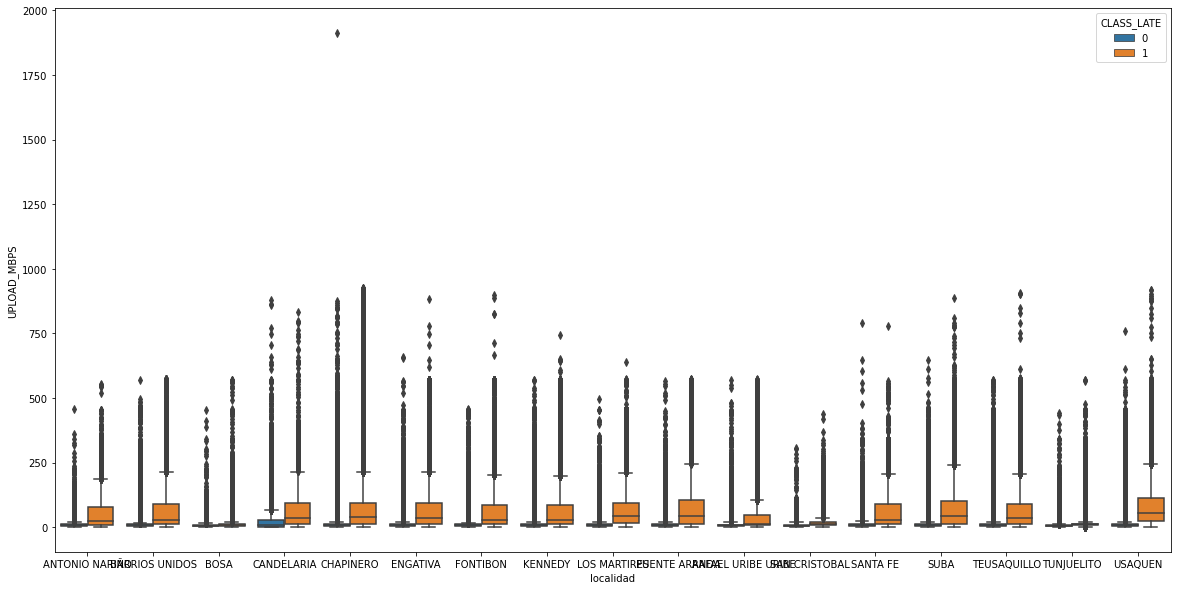

<Figure size 1440x720 with 0 Axes>

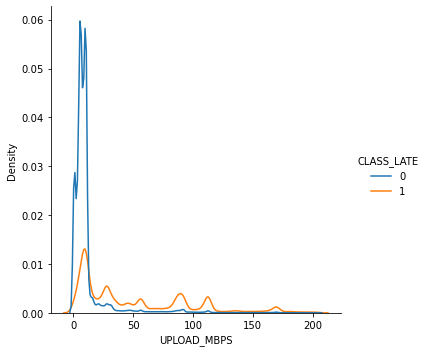

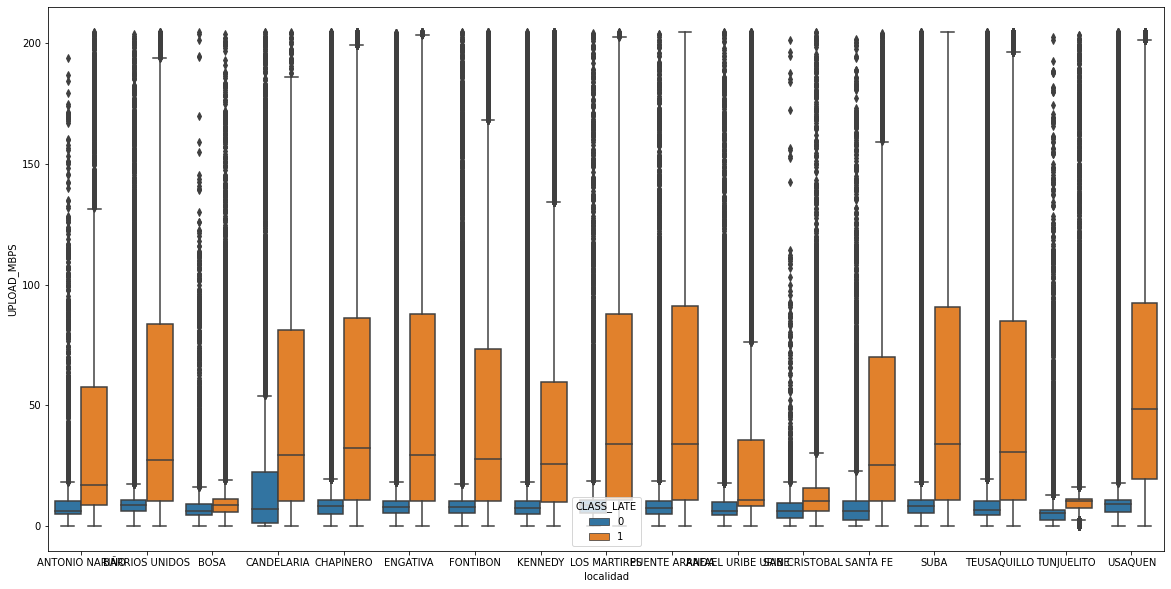

In [41]:
upload = density(bgt_df, 'UPLOAD_MBPS')

<Figure size 1440x720 with 0 Axes>

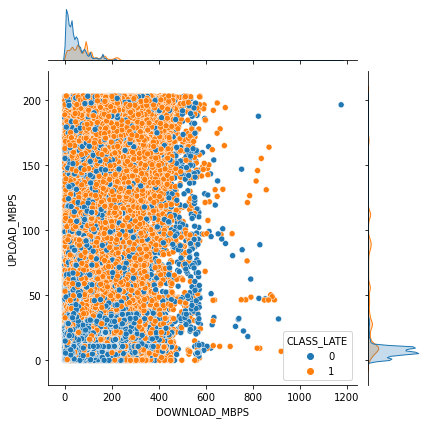

In [52]:
# plt.figure(figsize=(20,10))
# sns.jointplot(data=upload, x='DOWNLOAD_MBPS', y='UPLOAD_MBPS' , hue="CLASS_LATE")

# Mejor operador por localidad 

In [42]:
best_operador = bgt_df.pivot_table(values=['DOWNLOAD_MBPS','UPLOAD_MBPS'], index=['localidad','N_OPERADOR','MES','CLASS_LATE'], aggfunc=[np.median, np.mean])

In [43]:
best_operador.columns = best_operador.columns.map('_'.join)
best_operador.reset_index(inplace=True)
best_operador.to_csv('data/best_operador.csv', index=False)

In [44]:
def ffilter(x):
    download = x.sort_values(['median_DOWNLOAD_MBPS'], ascending=False)['N_OPERADOR'].iloc[0]
    upload = x.sort_values(['median_UPLOAD_MBPS'], ascending=False)['N_OPERADOR'].iloc[0]
    df = pd.DataFrame({'Boperador_DOWNLOAD_MBPS':[download], 'Boperador_UPLOAD_MBPS':[upload]})
    return df

best_operador = best_operador.groupby(['localidad','MES','CLASS_LATE']).apply(ffilter)

# # for key, name in best_operador

In [45]:
best_operador.reset_index(inplace=True)
best_operador.drop(columns=['level_3'], inplace=True)
best_operador

,localidad,MES,CLASS_LATE,Boperador_DOWNLOAD_MBPS,Boperador_UPLOAD_MBPS
0,ANTONIO NARIÑO,January,0,4,4
1,ANTONIO NARIÑO,January,1,1,1
2,ANTONIO NARIÑO,February,0,4,4
3,ANTONIO NARIÑO,February,1,1,1
4,ANTONIO NARIÑO,March,0,4,4
...,...,...,...,...,...
301,USAQUEN,July,1,3,3
302,USAQUEN,August,0,1,1
303,USAQUEN,August,1,3,3
304,USAQUEN,September,0,1,1


In [46]:
localidades = localidades.rename(columns={'NOMBRE':'localidad'})

bo_geo = best_operador.merge(localidades[['localidad','geometry']], how='inner', on='localidad')
bo_geo.head(5)

,localidad,MES,CLASS_LATE,Boperador_DOWNLOAD_MBPS,Boperador_UPLOAD_MBPS,geometry
0,ANTONIO NARIÑO,January,0,4,4,"POLYGON ((-74.13075 4.59335, -74.12917 4.59327..."
1,ANTONIO NARIÑO,January,1,1,1,"POLYGON ((-74.13075 4.59335, -74.12917 4.59327..."
2,ANTONIO NARIÑO,February,0,4,4,"POLYGON ((-74.13075 4.59335, -74.12917 4.59327..."
3,ANTONIO NARIÑO,February,1,1,1,"POLYGON ((-74.13075 4.59335, -74.12917 4.59327..."
4,ANTONIO NARIÑO,March,0,4,4,"POLYGON ((-74.13075 4.59335, -74.12917 4.59327..."


In [47]:
low_late = bo_geo[bo_geo.CLASS_LATE==1]
high_late = bo_geo[bo_geo.CLASS_LATE!=1]
low_late = gpd.GeoDataFrame(low_late, crs="EPSG:4326")
high_late = gpd.GeoDataFrame(high_late, crs="EPSG:4326")

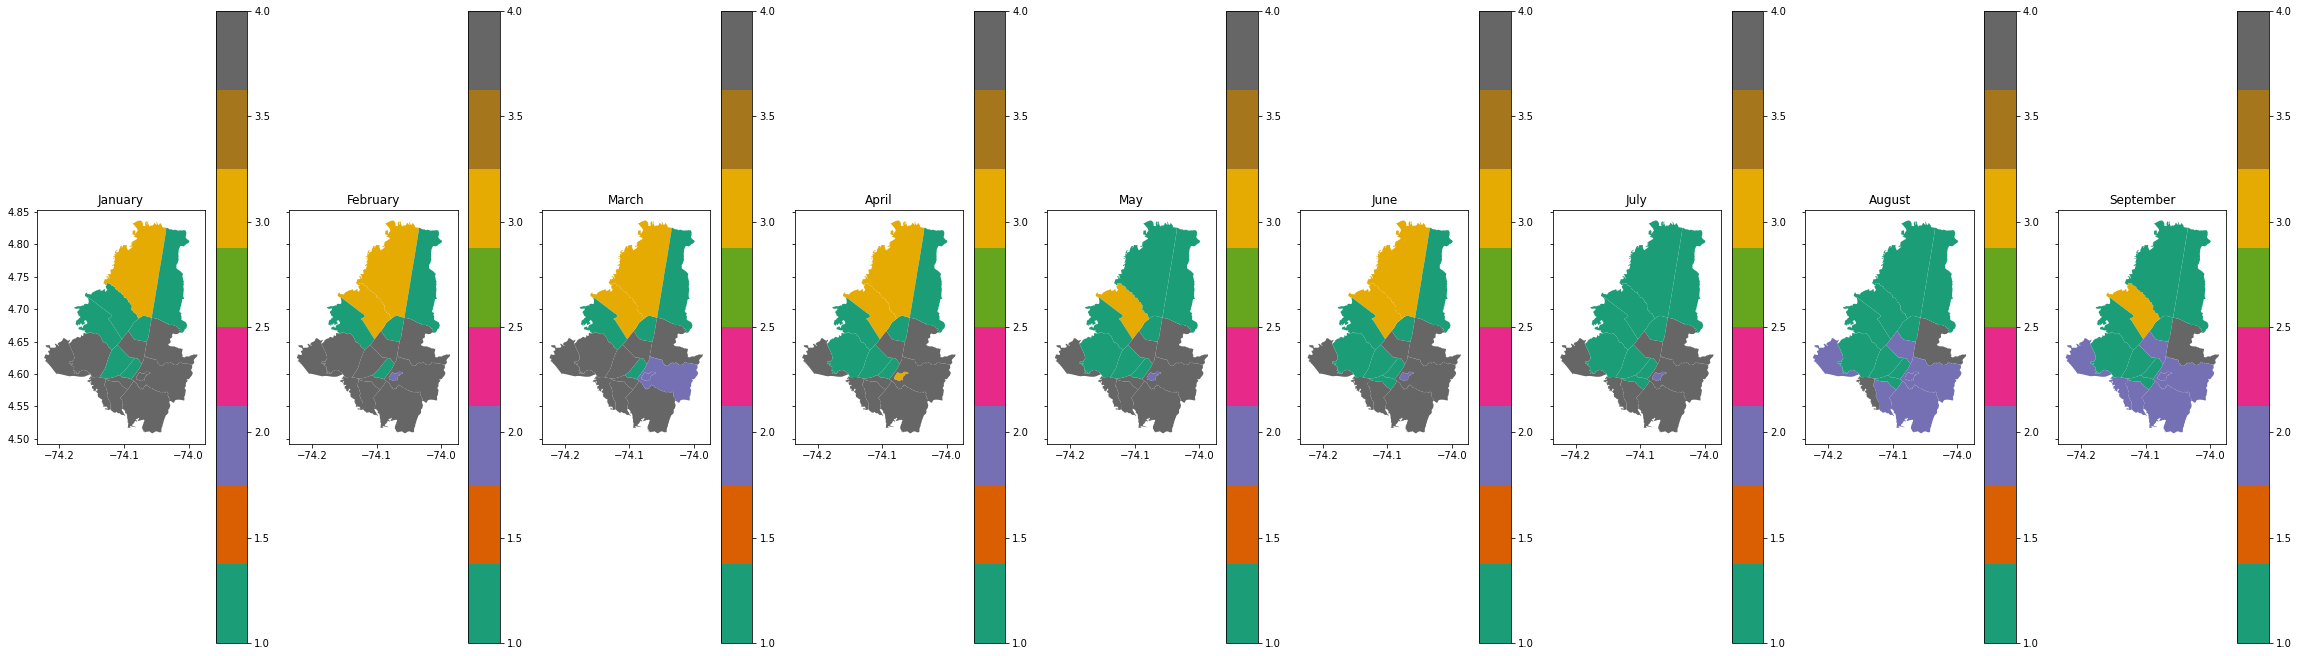

In [54]:
fig, axes = plt.subplots(1,9, figsize=(40,40),sharex=True, sharey=True)
for fid, mes in enumerate(high_late.MES.unique()):
    meses = high_late[high_late['MES']==mes]
    axes[fid].set_title(mes)
    meses.plot(ax=axes[fid], column='Boperador_UPLOAD_MBPS', cmap='Dark2', legend=True,vmin=1, vmax=4 )
plt.savefig('out/Boperador_UPLOAD_MBPS_high_late.png', dpi=400, )

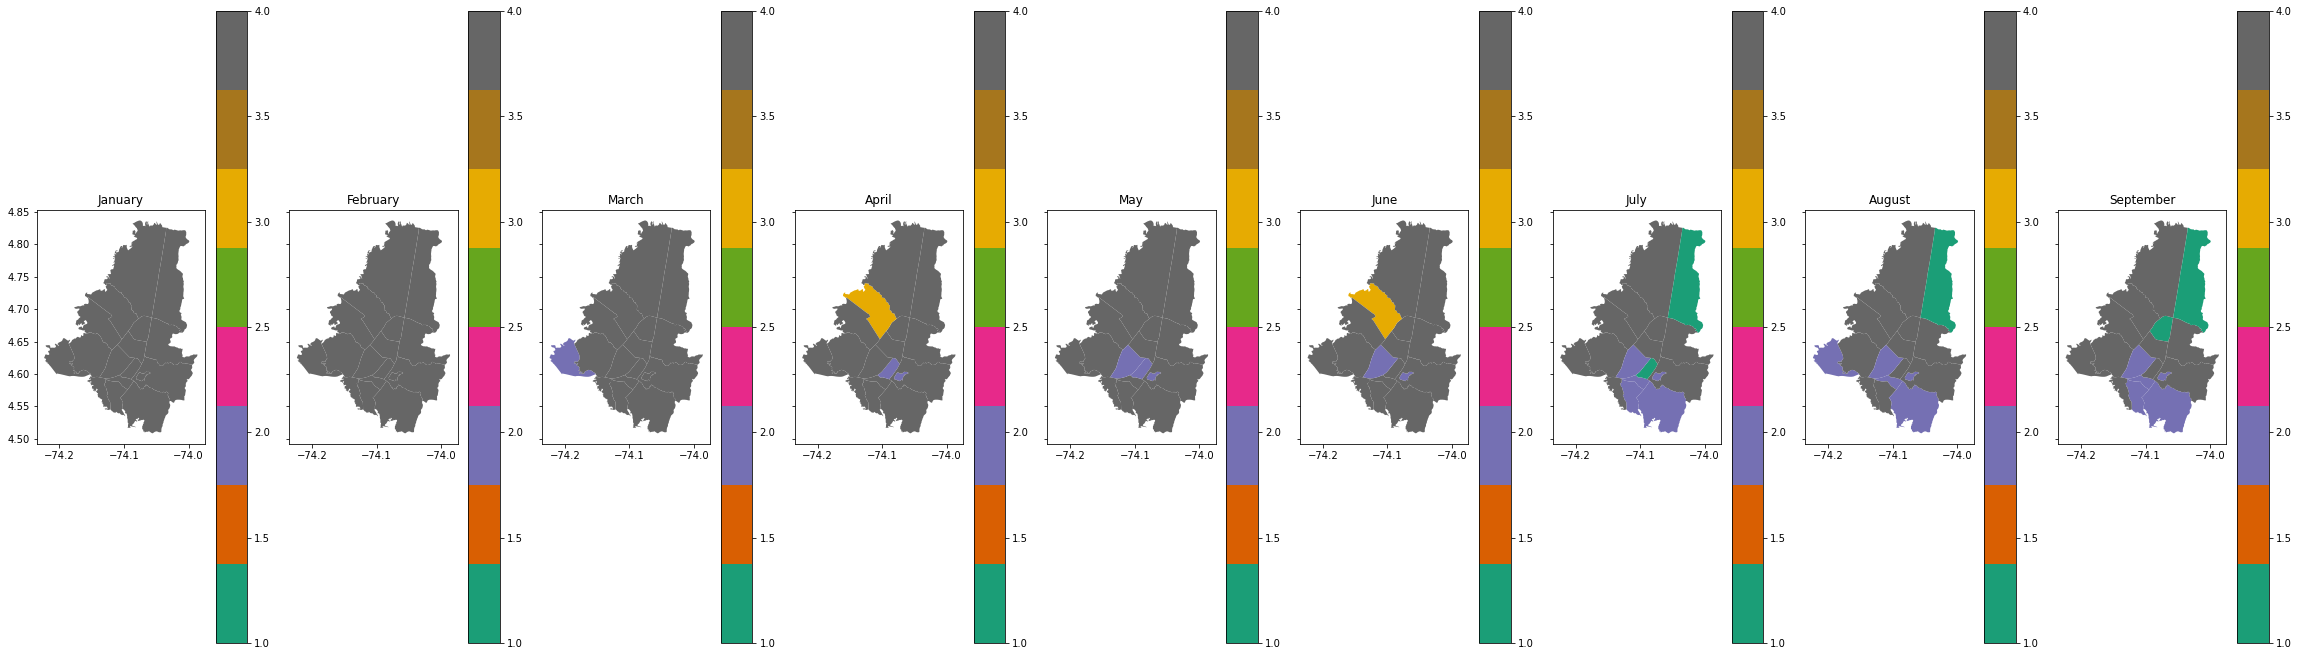

In [55]:
fig, axes = plt.subplots(1,9, figsize=(40,40),sharex=True, sharey=True)
for fid, mes in enumerate(high_late.MES.unique()):
    meses = high_late[high_late['MES']==mes]
    axes[fid].set_title(mes)
    meses.plot(ax=axes[fid], column='Boperador_DOWNLOAD_MBPS', cmap='Dark2', legend=True,vmin=1, vmax=4 )
plt.savefig('out/Boperador_DOWNLOAD_MBPS_high_late.png', dpi=400, )